In [1]:
!nvidia-smi

Mon Sep 23 22:23:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   47C    P8               6W / 185W |    441MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
"""
Resnet-18 for classifying roof materials from PlanetScope SuperDove imagery
Case study in Washington, D.C. 
"""

# Imports (many are imported in '__functions.py')

# Local imports
import os, sys, time, glob, gc
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils
from torchsat.models.classification import resnet18

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from fiona.crs import from_epsg
from shapely.geometry import box
from os.path import join

import matplotlib.cm as cm
import matplotlib.lines as mlines

import warnings
warnings.filterwarnings("ignore")

# Custom functions (__functions.py)
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Projection information
wgs = from_epsg(4326)
proj = from_epsg(32618)
print(f'Projected CRS: {proj}')

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan' # cyverse

print("Successfully imported all packages and functions !")

Projected CRS: EPSG:32618
Successfully imported all packages and functions !


In [3]:
# Prep the training data and image information

In [4]:
# Load the training data (footprints)
# gdf_path = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
gdf_path = join(homedir,'opp-data/dc_data_reference_footprints.gpkg')
ref = gpd.read_file(gdf_path)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [5]:
ref.class_code.value_counts()

class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64

In [6]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])

# Create a dictionary mapping class_code to code
code_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))

print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}
Description map: 
{'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'TL': 'Tile', 'WS': 'Wood shake/shingle', 'SH': 'Shingle'}


In [7]:
# Create the holdout data (independent from model training in CV)
holdout_fraction = 0.20 # excluding 20% of the data for holdout/independent testing
train_df, holdout_df, _ = split_training_data(ref, ts=holdout_fraction, vs=None) # no validation needed yet

print("Training set class distribution:\n", train_df[['class_code','code']].value_counts())
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Training set class distribution:
 class_code  code
CS          0       29706
ME          1       29491
SL          2       12213
UR          3        1023
WS          5         921
TL          4         739
SH          6         626
Name: count, dtype: int64
Holdout set class distribution:
 class_code  code
CS          0       7427
ME          1       7373
SL          2       3054
UR          3        256
WS          5        231
TL          4        185
SH          6        157
Name: count, dtype: int64


In [8]:
# Check on the image information

In [9]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'opp-data/dc_0623_psscene8b_final_norm.tif')
stack_da = rxr.open_rasterio(stack_da_fp, mask=True, cache=False).squeeze()
n_bands = stack_da.values.shape[:1][0] # get a list of band names
print(
    f"shape: {stack_da.rio.shape}\n"
    f"bands: {n_bands}\n"
    f"resolution: {stack_da.rio.resolution()}\n"
    f"bounds: {stack_da.rio.bounds()}\n"
    f"sum: {stack_da.sum().item()}\n"
    f"CRS: {stack_da.rio.crs}\n"
    f"NoData: {stack_da.rio.nodata}\n"
    f"Array: {stack_da}"
)
del stack_da

shape: (8223, 6714)
bands: 6
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Array: <xarray.DataArray (band: 6, y: 8223, x: 6714)> Size: 1GB
[331255332 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5')


In [10]:
# Set up the model development

In [11]:
# Define whether to leverage cpu or gpu (for my local machine it is only cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
print(f'Using {device} for model dev ...')

Using cuda for model dev ...


In [12]:
# Grab the number of classes
n_classes = ref.class_code.unique().shape[0]
print(f'There are {n_classes} roof type classes.\nTraining on {n_bands} bands.')

There are 7 roof type classes.
Training on 6 bands.


In [13]:
# Best params from tuning
params = {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 5}
print(f'Model params: {params}')

Model params: {'window_size': 78, 'batch_size': 64, 'learning_rate': 0.01, 'weight_decay': 0.01, 'momentum': 0.85, 'patience': 4}


In [14]:
# Function to initiate a Resnet-18 model
def initialize_resnet_model(n_classes, n_bands, device, learning_rate, momentum, weight_decay, patience):
    """
    Initializes the ResNet-18 model, optimizer, scheduler, scaler, and loss criterion.
    
    Args:
        n_classes (int): Number of output classes.
        n_bands (int): Number of input image bands.
        device (torch.device): Device to run the model on (CPU/GPU).
        learning_rate (float): Learning rate for the optimizer.
        momentum (float): Momentum for SGD optimizer.
        weight_decay (float): Weight decay for SGD optimizer.
        patience (int): Patience for learning rate scheduler.

    Returns:
        model (torch.nn.Module): The initialized model.
        optimizer (torch.optim.Optimizer): The optimizer.
        lr_scheduler (torch.optim.lr_scheduler): The learning rate scheduler.
        scaler (torch.cuda.amp.GradScaler): The scaler for mixed precision.
    """
    # Initialize the Resnet-18 model
    model = resnet18(n_classes, in_channels=n_bands, pretrained=False)
    # Move the model to the specified device
    if torch.cuda.device_count() >= 1:
        model = nn.DataParallel(model)
        model.to(device)
    else:
        model = nn.DataParallel(model)
        model.to(device)
        print('Made CPU parallel')

    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    
    # Define the learning rate scheduler
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=False, min_lr=1e-6)
    
    # Initialize the scaler for mixed precision
    scaler = torch.cuda.amp.GradScaler()

    return model, optimizer, lr_scheduler, scaler


def train_val_epoch(model, train_loader, val_loader, criterion, optimizer, scaler, device, lr_scheduler, epoch, print_freq):
    """
    Trains and validates the model for one epoch.
    
    Args:
        model (nn.Module): The model being trained/validated.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        scaler (torch.cuda.amp.GradScaler): Scaler for mixed precision training.
        device (torch.device): Device (CPU or GPU).
        epoch (int): The current epoch number.
        print_freq (int): Frequency of printing training progress.
        lr_scheduler (optional): Learning rate scheduler.

    Returns:
        dict: A dictionary containing train_loss, val_loss, val_accuracy, and val_f1 for the epoch.
    """
    t00 = time.time() # epoch start time
    
    # Training phase ...
    model.train()
    
    # Loop the training batches
    running_train_loss = 0 # to store the loss/batch
    freq_batch_train_losses = []
    for idx, batch in enumerate(train_loader):
        # Ensure a good batch
        batch = make_good_batch(batch)
        
        # Extract samples (image chunk, target label)
        image, target = batch['image'].to(device), batch['code'].to(device)

        optimizer.zero_grad() # reset the gradient

        # Use mixed precision
        with torch.cuda.amp.autocast():
            output = model(image.float())
            loss = criterion(output, target.long())
            # store all batch losses for calculate the epoch average
            running_train_loss += loss.item()
            
        scaler.scale(loss).backward()  # Mixed precision backward pass
        scaler.step(optimizer)  # Optimizer step
        scaler.update()

        # Print the train progress % and current loss
        if idx % print_freq == 0:
            print(f'\ttrain progress: [{idx * len(image)}/{len(train_loader.dataset)}] ({(100. * idx / len(train_loader)):.2f})%')
            print(f'\tbatch train loss: {loss.item():.4f};\tcumulative batch: {len(train_loader) * epoch + idx}')
            freq_batch_train_losses.append((idx, loss.item())) # append to batch losses list

        del image, target, batch, output, loss
                
    # average loss for the epoch (across batches)
    train_loss = running_train_loss / len(train_loader) # calculate the epoch loss
    # train_loss = np.array(batch_train_losses).mean()
    # train_losses.append(train_loss)

    # Validation phase ...
    model.eval()
    
    running_val_loss = 0
    running_correct = 0
    all_labs = []
    all_preds = []
    freq_batch_val_losses = []
    
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            # Ensure a good batch
            batch = make_good_batch(batch) 
            
            # Extract samples
            image, target = batch['image'].to(device), batch['code'].to(device)
            output = model(image.float())

            # Get validation loss and predictions
            running_val_loss += criterion(output, target).item()
            predicted = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            running_correct += predicted.eq(target.view_as(predicted)).sum().item() # Number of correct
            
            # Store the labels
            all_labs.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            if idx % print_freq == 0:
                freq_batch_val_losses.append((idx, criterion(output, target).item())) # append to batch losses list

            del image, target, batch, output
            
        # val_loss /= len(val_loader.dataset)/val_loader.batch_size
        val_loss = running_val_loss / len(val_loader)
        # val_losses.append(val_loss)
    
    print(f"\nEpoch [{epoch}] completed.")
    print(f'\ttrain loss: {train_loss}; validation loss = {val_loss:.4f}')

    acc = 100. * running_correct / len(val_loader.dataset)
    f1 = f1_score(all_labs, all_preds, average="weighted")
    print(f'\tAccuracy (validation): [{running_correct}/{len(val_loader.dataset)}] ({acc:.4f})%;\n\tF1-score (validation): {f1:.4f}')

    # Adjust the learning rate based on the validation loss
    lr_scheduler.step(val_loss)
    if optimizer.param_groups[0]['lr'] != current_lr:
        print(f"! LR-Scheduler [ReduceLROnPlateau] adjustment: {optimizer.param_groups[0]['lr']} !")
     
    t1 = (time.time() - t00) / 60
    print(f"Time to complete epoch [{epoch}]: {t1:.2f} minutes.")
    print("~~~~~~~~~~\n")

    return {
        'epoch_train_loss': train_loss,
        'batch_train_losses': freq_batch_train_losses,
        'epoch_val_loss': val_loss,
        'batch_val_losses': freq_batch_val_losses,
        'val_acc': acc,
        'val_f1': f1,
        'val_labs': all_labs,
        'val_preds': all_preds
    }
    

print("Model initiation and train/validation functions ready !")

Model initiation and train/validation functions ready !


In [4]:
results_dir = os.path.join(homedir,'results/resnet18-cv/')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving results to {results_dir}")

Saving results to /home/jovyan/results/resnet18-cv/


In [16]:
start = time.time()

# Set up the cross-validation for the training data (ignoring the holdout data)
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=44)

# Set up method for storing fold results
fold_results = {
    'fold_id': [],
    'epoch': [],
    'epoch_train_loss': [],
    'batch_train_losses': [],
    'epoch_val_loss': [],
    'batch_val_losses': [],
    'val_acc': [],
    'val_f1': [],
    'val_labs': [],
    'val_preds': []
}

num_epochs = 20 # how many epochs are we running?

# Iterate through each fold
for fold_id, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['class_code'])):
    t0 = time.time()
    
    print(f"Processing fold {fold_id + 1}/{n_folds}...")

    # Get the train and validation splits for this fold
    fold_train = train_df.iloc[train_idx]
    fold_val = train_df.iloc[val_idx]

    # Apply random undersampling to the training data within this fold
    fold_train_bal = balance_sampling(fold_train, ratio=5, strategy='undersample')
    # Display the class distribution in the undersampled training data for this fold
    print(f"Train class distribution (fold {fold_id + 1}):\n", fold_train_bal['code'].value_counts().to_dict())
    print(f"Validation class distribution (fold {fold_id + 1}):\n", fold_val['code'].value_counts().to_dict())

    # Calculate the class weights for the cross entropy loss function
    val_counts = fold_train_bal['code'].value_counts()
    total_samples = sum(val_counts)
    class_weights = np.array([total_samples / count for count in val_counts])
    class_weights_n = class_weights / class_weights.sum() # normalize the weights
    class_weights_n = torch.tensor(class_weights_n, dtype=torch.float).to(device)
    del val_counts, total_samples, class_weights # clean up some
    
    # Create DataLoader for this fold's training and validation sets

    # Training/validation dataset creation
    train_ds = RoofImageDatasetPlanet(fold_train_bal[['geometry', 'code']], img_path=stack_da_fp, n_bands=n_bands, img_dim=params['window_size'])
    val_ds = RoofImageDatasetPlanet(fold_val[['geometry', 'code']], img_path=stack_da_fp, n_bands=n_bands, img_dim=params['window_size'])
    # Load the datasets to torch
    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], num_workers=2, shuffle=True, pin_memory=True) # use num workers for training only
    val_loader = DataLoader(val_ds, batch_size=params['batch_size'] * 2, num_workers=2, shuffle=False, pin_memory=True) # increase batch size for validation
    print(f"Data loaded for fold: {fold_id + 1}\n")

    # Initialize the Resnet-18 model
    model, optimizer, lr_scheduler, scaler = initialize_resnet_model(
        n_classes=n_classes,
        n_bands=n_bands,
        device=device,
        learning_rate=params['learning_rate'],
        momentum=params['momentum'],
        weight_decay=params['weight_decay'],
        patience=params['patience']
    )

    # Define the loss function with the class weights defined above
    criterion = nn.CrossEntropyLoss(weight=class_weights_n).to(device)
    
    del fold_train, fold_val, fold_train_bal # clean up some
    gc.collect()

    # Model training and validation ...

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []

    print_freq = int(len(train_loader) // 4) # quarterly print statements
    
    for epoch in range(1, num_epochs + 1):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch}]. Current learning rate: {current_lr}")
        
        # Train and validate for the epoch
        epoch_results = train_val_epoch(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
            lr_scheduler=lr_scheduler,
            epoch=epoch,
            print_freq=print_freq
        )
        
        # Store epoch metrics
        fold_results['fold_id'].append(fold_id)
        fold_results['epoch'].append(epoch)
        fold_results['epoch_train_loss'].append(epoch_results['epoch_train_loss'])
        fold_results['batch_train_losses'].append(epoch_results['batch_train_losses'])
        fold_results['epoch_val_loss'].append(epoch_results['epoch_val_loss'])
        fold_results['batch_val_losses'].append(epoch_results['batch_val_losses'])
        fold_results['val_acc'].append(epoch_results['val_acc'])
        fold_results['val_f1'].append(epoch_results['val_f1'])
        fold_results['val_labs'].append(epoch_results['val_labs'])
        fold_results['val_preds'].append(epoch_results['val_preds'])

        # Adjust the learning rate based on the validation loss for the epoch
        lr_scheduler.step(epoch_results['epoch_val_loss'])
        if optimizer.param_groups[0]['lr'] != current_lr:
            print(f"! LR-Scheduler [ReduceLROnPlateau] adjustment: {optimizer.param_groups[0]['lr']} !")

        gc.collect() # do a garbage cleanup
        torch.cuda.empty_cache() # empty the GPU

    # Save the model for the current fold
    model_fn = f'dc-resnet18_fold{fold_id + 1}.pth'
    model_fp = os.path.join(results_dir, model_fn)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': epoch_results['epoch_val_loss'],
        'params': params  # Save training parameters for reproducibility
    }, model_fp)
    
    t2 = (time.time() - t0) / 60
    print(f"Total elapsed time for fold [{fold_id + 1}]: {t2:.2f} minutes.")
    print("\n~~~~~~~~~~\n")
    
    # Memory management !
    del train_ds, train_loader, val_ds, val_loader # clear up the memory
    gc.collect() # do a garbage cleanup
    torch.cuda.empty_cache() # empty the GPU

t3 = (time.time() - start) / 60
print(f"Total elapsed time: {t3:.2f} minutes.")

Processing fold 1/5...
Train class distribution (fold 1):
 {0: 2505, 1: 2505, 2: 2505, 3: 818, 5: 737, 4: 591, 6: 501}
Validation class distribution (fold 1):
 {0: 5942, 1: 5898, 2: 2442, 3: 205, 5: 184, 4: 148, 6: 125}
Data loaded for fold: 1

Epoch [1]. Current learning rate: 0.01
	train progress: [0/10162] (0.00)%
	batch train loss: 1.9824;	cumulative batch: 159
	train progress: [2496/10162] (24.53)%
	batch train loss: 1.5670;	cumulative batch: 198
	train progress: [4992/10162] (49.06)%
	batch train loss: 1.8935;	cumulative batch: 237
	train progress: [7488/10162] (73.58)%
	batch train loss: 1.8302;	cumulative batch: 276
	train progress: [9984/10162] (98.11)%
	batch train loss: 1.5859;	cumulative batch: 315

Epoch [1] completed.
	train loss: 1.6309034704412304; validation loss = 1.4619
	Accuracy (validation): [4268/14944] (28.5600)%;
	F1-score (validation): 0.3636
Time to complete epoch [1]: 3.21 minutes.
~~~~~~~~~~

Epoch [2]. Current learning rate: 0.01
	train progress: [0/10162] 

In [17]:
gc.collect()

0

In [23]:
# Save the fold results
fold_results_df = pd.DataFrame(fold_results)
fold_results_df.to_csv(os.path.join(results_dir, 'dc-resnet18_cv_fold_results.csv'))

In [24]:
# Save the holdout data
holdout_df.to_file(os.path.join(results_dir, 'dc-resnet18_cv_holdout_ref.gpkg'))

In [ ]:
# Plot the model results and save outputs

In [5]:
# (optional) Load the fold results data frame
fold_results_df = pd.read_csv(os.path.join(results_dir, 'dc-resnet18_cv_fold_results.csv'))

In [6]:
print(fold_results_df.head())

   Unnamed: 0  fold_id  epoch  epoch_train_loss  \
0           0        0      1          1.630903   
1           1        0      2          1.467624   
2           2        0      3          1.296397   
3           3        0      4          1.151769   
4           4        0      5          1.022296   

                                  batch_train_losses  epoch_val_loss  \
0  [(0, 1.982433795928955), (39, 1.56697738170623...        1.461854   
1  [(0, 1.5513917207717896), (39, 1.6158186197280...        1.280799   
2  [(0, 1.1642735004425049), (39, 1.1436913013458...        1.121322   
3  [(0, 1.076288104057312), (39, 0.98370331525802...        1.504949   
4  [(0, 0.9027209281921387), (39, 0.9470928907394...        1.811013   

                                    batch_val_losses    val_acc    val_f1  \
0  [(0, 1.5675806999206543), (39, 1.5584994554519...  28.559957  0.363565   
1  [(0, 1.2759952545166016), (39, 1.3712044954299...  56.022484  0.634323   
2  [(0, 1.2659144401550293), 

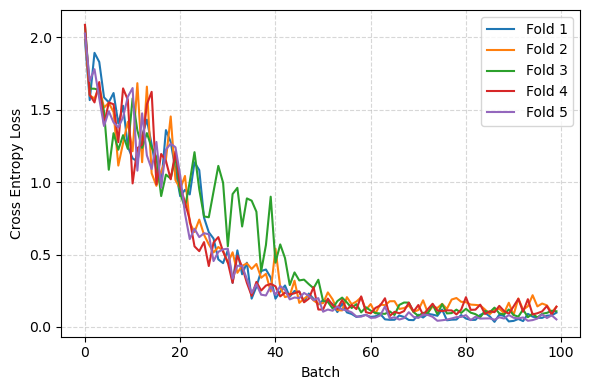

In [9]:
# Plot the batch train losses
import ast

plt.figure(figsize=(6, 4))

linestyles = ['-', '--']

n_folds = 5
for fold_idx in range(n_folds):
    # Extract batch train losses for the current fold and all epochs
    fold_df = fold_results_df[fold_results_df['fold_id'] == fold_idx]
    
    all_batch_train_losses = []
    
    for batch_losses_str in fold_df['batch_train_losses']:
        # Convert the string representation of list of tuples back to list of tuples
        batch_losses = ast.literal_eval(batch_losses_str) if isinstance(batch_losses_str, str) else batch_losses_str
        all_batch_train_losses.extend([loss for _, loss in batch_losses])

    # Plot all batch train losses for this fold
    plt.plot(all_batch_train_losses, label=f'Fold {fold_idx + 1}')
   
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/dc-resnet18_cv_batch_train_loss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

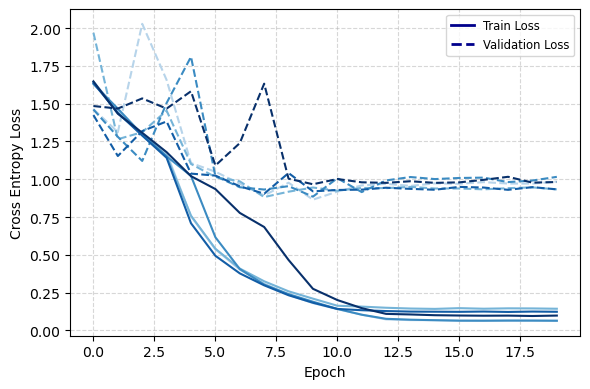

In [10]:
plt.figure(figsize=(6, 4))

# Extract the average validation loss for each fold
fold_avg_val_loss = fold_results_df.groupby('fold_id')['epoch_val_loss'].min().reset_index()
# Sort by the validation loss to determine the order of shading
sorted_folds = fold_avg_val_loss.sort_values(by='epoch_val_loss', ascending=True)['fold_id'].values
# Create a color gradient from light to dark blue
colors = plt.cm.Blues(np.linspace(0.3, 1, len(sorted_folds)))  # Adjust the range for a clearer gradient

# Plot train and validation loss for each fold in the order of sorted validation loss
for idx, fold_idx in enumerate(sorted_folds):
    # Extract the data for the current fold
    fold_data = fold_results_df[fold_results_df['fold_id'] == fold_idx]
    epoch_train_losses = fold_data['epoch_train_loss'].values
    epoch_val_losses = fold_data['epoch_val_loss'].values

    # Plot train/val loss with the corresponding color
    plt.plot(epoch_train_losses, color=colors[idx], linestyle='-')
    plt.plot(epoch_val_losses, color=colors[idx], linestyle='--')

# Add legend for only train and validation loss
dark_blue = '#00008B'  # Hex code for dark blue
train_line = plt.Line2D([0], [0], color=dark_blue, lw=2, linestyle='-')
val_line = plt.Line2D([0], [0], color=dark_blue, lw=2, linestyle='--')
plt.legend([train_line, val_line], ['Train Loss', 'Validation Loss'], loc='upper right', fontsize='small')

plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot
out_png = os.path.join(results_dir, 'figures/dc-resnet18_cv_epoch_trainval_loss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

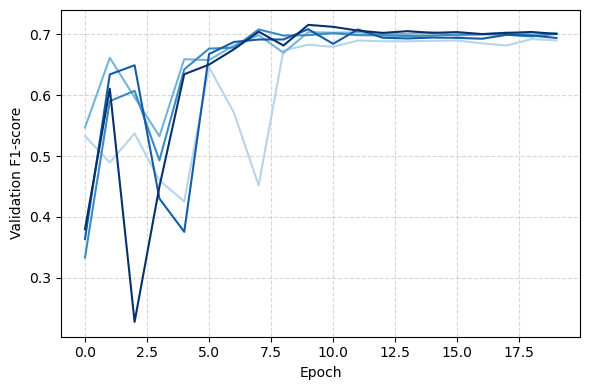

In [11]:
# Same plot but for F1-score
plt.figure(figsize=(6, 4))

# Extract the average validation loss for each fold
fold_avg_f1 = fold_results_df.groupby('fold_id')['val_f1'].max().reset_index()
# Sort by the validation loss to determine the order of shading
sorted_folds = fold_avg_f1.sort_values(by='val_f1', ascending=True)['fold_id'].values
colors = plt.cm.Blues(np.linspace(0.3, 1, len(sorted_folds)))  # Adjust the range for a clearer gradient

# Plot train and validation loss for each fold in the order of sorted validation loss
for idx, fold_idx in enumerate(sorted_folds):
    # Extract the data for the current fold
    fold_data = fold_results_df[fold_results_df['fold_id'] == fold_idx]
    epoch_f1 = fold_data['val_f1'].values
    
    # Plot train/val loss with the corresponding color
    plt.plot(epoch_f1, color=colors[idx], linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Validation F1-score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot
out_png = os.path.join(results_dir, 'figures/dc-resnet18_cv_epoch_valF1score.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Perform predictions on the holdout data for each model

In [13]:
# (optional) load the holdout data
holdout_df = gpd.read_file(os.path.join(results_dir, 'dc-resnet18_cv_holdout_ref.gpkg'))

In [14]:
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Holdout set class distribution:
 class_code  code
CS          0       7427
ME          1       7373
SL          2       3054
UR          3        256
WS          5        231
TL          4        185
SH          6        157
Name: count, dtype: int64


In [16]:
# Create dictionaries for mapping
code_mapping = dict(zip(holdout_df['code'], holdout_df['class_code']))  # Mapping to original 'class_code'
desc_mapping = dict(zip(holdout_df['code'], holdout_df['description']))
print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{0: 'CS', 1: 'ME', 2: 'SL', 3: 'UR', 4: 'TL', 5: 'WS', 6: 'SH'}
Description map: 
{0: 'Composition Shingle', 1: 'Metal', 2: 'Slate', 3: 'Urethane', 4: 'Tile', 5: 'Wood shake/shingle', 6: 'Shingle'}


In [48]:
# Load the holdout data
holdout_ds = RoofImageDatasetPlanet(holdout_df[['geometry', 'code']], img_path=stack_da_fp, n_bands=n_bands, img_dim=params['window_size'])
holdout_loader = DataLoader(holdout_ds, batch_size=params['batch_size'] * 2, num_workers=2, shuffle=False, pin_memory=True)
print("Holdout data loaded !")

Holdout data loaded !


In [116]:
# Initialize list to store the results:
all_preds = []
# loop the trained models and make predictions
for fold_idx in range(1, n_folds + 1):
    print(f"Making predictions with model from fold {fold_idx}")

    # Load the trained model for the current fold
    model_fp = os.path.join(results_dir, f'dc-resnet18_fold{fold_idx}.pth')
    print(f"Loading model from path: {model_fp}")
    checkpoint = torch.load(model_fp, map_location=device)

    # Initialize the model architecture
    model, _, _, _ = initialize_resnet_model(
        n_classes=n_classes,
        n_bands=n_bands,
        device=device,
        learning_rate=params['learning_rate'],
        momentum=params['momentum'],
        weight_decay=params['weight_decay'],
        patience=params['patience']
    )

    # Load the trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    
    true_codes = []
    pred_codes = []

    # Make predictions on the holdout data
    with torch.no_grad():
        for idx, sample in enumerate(holdout_loader):
            image, label = sample['image'].to(device), sample['code'].to(device)

            # Get the model's predictions
            output = model(image.float())
            predictions = output.argmax(dim=1).cpu().numpy()

            # Store true labels and predictions
            true_codes.extend(label.cpu().numpy())
            pred_codes.extend(predictions)

            if idx % 10 == 0:
                print(f"\tProcessed {idx * params['batch_size']} samples")

    # Map true and predicted labels to their class codes
    true_class_codes = [code_mapping[code] for code in true_codes]
    pred_class_codes = [code_mapping[pred] for pred in pred_codes]

    fold_df = pd.DataFrame({
        'fold_idx': fold_idx,         
        'true_code': true_codes,
        'pred_code': pred_codes,
        'true_label': true_class_codes,
        'pred_label': pred_class_codes
    })

    all_preds.append(fold_df)

    del model
    torch.cuda.empty_cache()
    gc.collect()

# concatenate across folds
preds_df = pd.concat(all_preds, ignore_index=True)

# Save the predictions for later analysis
preds_df.to_csv(os.path.join(results_dir, 'dc-resnet18_cv_holdout_preds.csv'), index=False)
print("Completed predictions for all folds!")

Making predictions with model from fold 1
	Processed 0 samples
	Processed 640 samples
	Processed 1280 samples
	Processed 1920 samples
	Processed 2560 samples
	Processed 3200 samples
	Processed 3840 samples
	Processed 4480 samples
	Processed 5120 samples
	Processed 5760 samples
	Processed 6400 samples
	Processed 7040 samples
	Processed 7680 samples
	Processed 8320 samples
	Processed 8960 samples
Making predictions with model from fold 2
	Processed 0 samples
	Processed 640 samples
	Processed 1280 samples
	Processed 1920 samples
	Processed 2560 samples
	Processed 3200 samples
	Processed 3840 samples
	Processed 4480 samples
	Processed 5120 samples
	Processed 5760 samples
	Processed 6400 samples
	Processed 7040 samples
	Processed 7680 samples
	Processed 8320 samples
	Processed 8960 samples
Making predictions with model from fold 3
	Processed 0 samples
	Processed 640 samples
	Processed 1280 samples
	Processed 1920 samples
	Processed 2560 samples
	Processed 3200 samples
	Processed 3840 sample

In [18]:
# (optional) Load the prediction dataframe
preds_df = pd.read_csv(os.path.join(results_dir, 'dc-resnet18_cv_holdout_preds.csv'))

In [ ]:
# Plot the number of correct predictions by class/fold

In [19]:
preds_df.dtypes

fold_idx       int64
true_code      int64
pred_code      int64
true_label    object
pred_label    object
dtype: object

In [20]:
preds_df.head()

,fold_idx,true_code,pred_code,true_label,pred_label
0,1,0,0,CS,CS
1,1,0,0,CS,CS
2,1,0,2,CS,SL
3,1,0,0,CS,CS
4,1,0,2,CS,SL


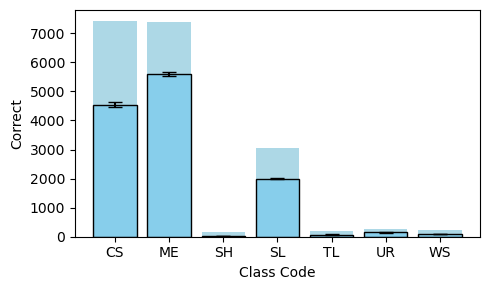

In [24]:
# Create a DataFrame for plotting correct predictions by class code across folds
preds_df['correct'] = preds_df['true_label'] == preds_df['pred_label']
preds_df_correct = preds_df.groupby(['fold_idx', 'true_label']).agg(correct_count=('correct', 'sum')).reset_index()
preds_df_correct = preds_df_correct.groupby('true_label')['correct_count'].agg(['mean', 'std']).reset_index()

# Get total counts of true labels
total_counts = preds_df.groupby(['fold_idx', 'true_label']).size().reset_index(name='total_count')
total_counts_mn = total_counts.groupby('true_label')['total_count'].mean().reset_index()

# Merge back to data frame
preds_df_correct = preds_df_correct.merge(total_counts_mn, on='true_label', how='left')

plt.figure(figsize=(5, 3))

plt.bar(preds_df_correct['true_label'], preds_df_correct['total_count'], color='lightblue', label='Total Samples')
plt.bar(preds_df_correct['true_label'], preds_df_correct['mean'], yerr=preds_df_correct['std'], 
        capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Class Code')
plt.ylabel('Correct')
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/dc-resnet18_cv_correct_preds.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Generate the classification report

In [25]:
all_reports = [] # to store the classification reports for each fold
class_codes = list(preds_df['true_label'].unique())
print(class_codes)

# Iterate over the folds
for fold_idx in preds_df['fold_idx'].unique():
    print(f"Create CR for fold [{fold_idx}]")

    fold_preds_df = preds_df[preds_df['fold_idx'] == fold_idx]

    print(fold_preds_df.correct.value_counts())
    
    # Gather the true and predicted labels
    true_labs_fold = fold_preds_df['true_label']
    pred_labs_fold = fold_preds_df['pred_label']

    # Generate the classification report
    cr_fold = pd.DataFrame(classification_report(true_labs_fold, pred_labs_fold, output_dict=True)).transpose()
    cr_fold['fold_idx'] = fold_idx
    cr_fold = cr_fold.reset_index().rename(columns={'index': 'class_code'})
    cr_fold = cr_fold[cr_fold['class_code'].isin(class_codes)] # keep only the per class metrics (i.e., not the weighted average)
    all_reports.append(cr_fold)

# Combine the reports
cr_df = pd.concat(all_reports, axis=0)

# Save the report as a CSV
cr_df.to_csv(os.path.join(results_dir, 'dc-resnet18_cv_classification_reports.csv'))
print(cr_df)

['CS', 'ME', 'SL', 'UR', 'TL', 'WS', 'SH']
Create CR for fold [1]
correct
True     12425
False     6258
Name: count, dtype: int64
Create CR for fold [2]
correct
True     12539
False     6144
Name: count, dtype: int64
Create CR for fold [3]
correct
True     12380
False     6303
Name: count, dtype: int64
Create CR for fold [4]
correct
True     12551
False     6132
Name: count, dtype: int64
Create CR for fold [5]
correct
True     12511
False     6172
Name: count, dtype: int64
  class_code  precision    recall  f1-score  support  fold_idx
0         CS   0.796767  0.603878  0.687040   7427.0         1
1         ME   0.867837  0.757900  0.809151   7373.0         1
2         SH   0.103976  0.216561  0.140496    157.0         1
3         SL   0.453327  0.653569  0.535336   3054.0         1
4         TL   0.207386  0.394595  0.271881    185.0         1
5         UR   0.156746  0.617188  0.250000    256.0         1
6         WS   0.173333  0.393939  0.240741    231.0         1
0         CS   0.7

In [26]:
# Calculate the mean metrics across all folds
cr_summary = cr_df[['class_code', 'precision', 'recall', 'f1-score']].groupby('class_code').agg(['mean', 'std']).reset_index()
cr_summary.columns = ['class_code', 'precision', 'precision_sd', 
                      'recall', 'recall_sd', 
                      'f1-score', 'f1-score_sd']
cr_summary

,class_code,precision,precision_sd,recall,recall_sd,f1-score,f1-score_sd
0,CS,0.802699,0.006256,0.612145,0.011981,0.694515,0.007219
1,ME,0.866101,0.006813,0.757683,0.009367,0.808212,0.003179
2,SH,0.104975,0.011842,0.228025,0.020835,0.143426,0.013380
3,SL,0.466727,0.009975,0.655010,0.009217,0.545022,0.008574
4,TL,0.204628,0.024327,0.405405,0.033540,0.270296,0.015983
5,UR,0.145423,0.009881,0.581250,0.030683,0.232586,0.014651
6,WS,0.166055,0.023932,0.382684,0.030396,0.230836,0.025927


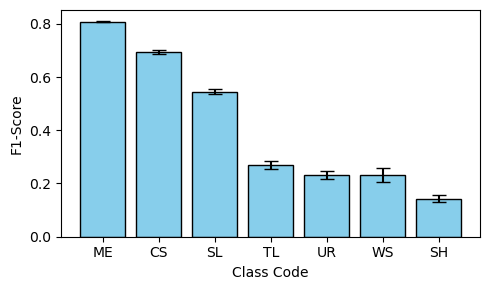

In [27]:
cr_summary = cr_summary.sort_values(by='f1-score', ascending=False)

plt.figure(figsize=(5, 3))
plt.bar(cr_summary['class_code'], cr_summary['f1-score'], 
        yerr=cr_summary['f1-score_sd'], capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Class Code')
plt.ylabel('F1-Score')
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/dc-resnet18_cv_mean_f1-score_bar.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Find the best model from the folds

In [28]:
f1_scores_wt = [] # to store the weighted f1-scores
for fold_idx in cr_df['fold_idx'].unique():
    # Filter data for the current fold
    fold_data = cr_df[cr_df['fold_idx'] == fold_idx]
    
    # Calculate the weighted F1-score for this fold
    total_support = fold_data['support'].sum()
    weighted_f1 = (fold_data['f1-score'] * fold_data['support']).sum() / total_support
    
    # Append the results
    f1_scores_wt.append({'fold_idx': fold_idx, 'weighted_f1_score': weighted_f1})

# Convert to a DataFrame
f1_scores_wt_df = pd.DataFrame(f1_scores_wt)

# Step 2: Identify the best-performing fold
best_fold = f1_scores_wt_df.loc[f1_scores_wt_df['weighted_f1_score'].idxmax()]
print(f"Best performing fold is Fold {int(best_fold['fold_idx'])} with a weighted F1-score of {best_fold['weighted_f1_score']:.4f}")

Best performing fold is Fold 2 with a weighted F1-score of 0.6980


In [29]:
best_fold_df = preds_df[preds_df['fold_idx'] == int(best_fold['fold_idx'])]
best_fold_df.head()

,fold_idx,true_code,pred_code,true_label,pred_label,correct
18683,2,0,6,CS,SH,False
18684,2,0,0,CS,CS,True
18685,2,0,2,CS,SL,False
18686,2,0,0,CS,CS,True
18687,2,0,2,CS,SL,False


In [ ]:
# Retrieve the classification report for the best model

In [30]:
# Gather the true and predicted labels
true_labs_fold = best_fold_df['true_label']
pred_labs_fold = best_fold_df['pred_label']

# Generate the classification report
cr_best = pd.DataFrame(classification_report(true_labs_fold, pred_labs_fold, output_dict=True)).transpose()
print(cr_best)

              precision    recall  f1-score       support
CS             0.798214  0.625825  0.701585   7427.000000
ME             0.876156  0.745558  0.805598   7373.000000
SH             0.109333  0.261146  0.154135    157.000000
SL             0.478271  0.670269  0.558222   3054.000000
TL             0.242647  0.356757  0.288840    185.000000
UR             0.144455  0.605469  0.233258    256.000000
WS             0.145051  0.367965  0.208078    231.000000
accuracy       0.671145  0.671145  0.671145      0.671145
macro avg      0.399161  0.518998  0.421388  18683.000000
weighted avg   0.748349  0.671145  0.697991  18683.000000


In [ ]:
# Generate confusion matrices

In [164]:
class_names = list(code_mapping.values())
print(class_names)

['CS', 'ME', 'SL', 'UR', 'TL', 'WS', 'SH']


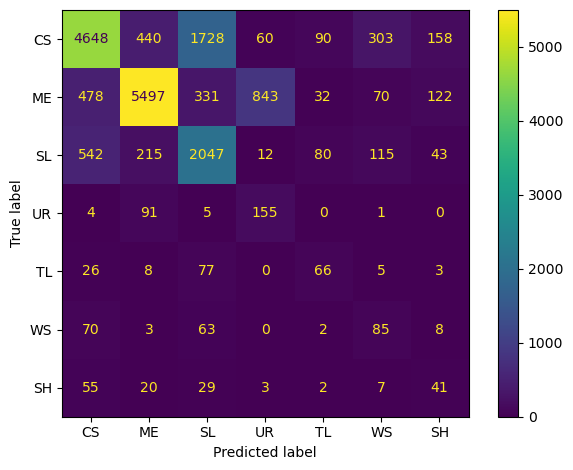

In [167]:
# For the best performing model (Fold 2)
best_fold_df = preds_df[preds_df['fold_idx'] == int(best_fold['fold_idx'])]
cm_best = confusion_matrix(
    best_fold_df['true_label'], 
    best_fold_df['pred_label'], 
    labels=class_names)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=class_names)
disp.plot(cmap='viridis')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/dc-resnet18_confusion_matrix_bestFold.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()

In [ ]:
# Average across folds

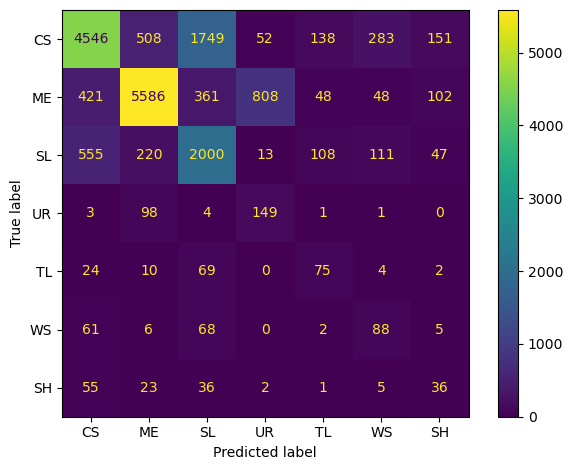

In [163]:
average_cm = np.zeros((len(class_names), len(class_names)))

# Iterate through each fold and accumulate the confusion matrix
for fold_idx in preds_df['fold_idx'].unique():
    fold_preds = preds_df[preds_df['fold_idx'] == fold_idx]
    cm_fold = confusion_matrix(
        fold_preds['true_label'], 
        fold_preds['pred_label'], 
        labels=class_names
    )
    average_cm += cm_fold

# Divide by the number of folds to get the average
average_cm /= len(preds_df['fold_idx'].unique())
average_cm = np.rint(average_cm).astype(int)

# Plot the confusion matrix
disp_avg = ConfusionMatrixDisplay(confusion_matrix=average_cm, display_labels=class_names)
disp_avg.plot(cmap='viridis', values_format='d')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/dc-resnet18_confusion_matrix_average.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()